# TP 3 

## Import des Librairies

In [69]:
!pip install keras
!pip install tensorflow
!pip install PrettyTable

In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import math as math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU
from keras.layers import Dropout
from keras.layers import *
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor, GradientBoostingRegressor
from joblib import parallel_backend

from time import time
from tensorflow.keras.callbacks import TensorBoard
import warnings
warnings.filterwarnings('ignore')

In [71]:
données = pd.read_fwf('SPX.txt', names=['date', 'valeur'])


In [72]:
données

,date,valeur
0,06/01/1995,"460,68"
1,13/01/1995,"465,97"
2,20/01/1995,"464,78"
3,27/01/1995,"470,39"
4,03/02/1995,"478,64"
...,...,...
1287,06/09/2019,"2978,7"
1288,13/09/2019,"3007,3"
1289,20/09/2019,"2992,0"
1290,27/09/2019,"2961,7"


In [73]:
données['valeur']=données['valeur'].apply(lambda x: x.replace(',', '.'))

In [74]:
données['valeur']= données['valeur'].astype(float)

In [75]:
volatilité = pd.read_fwf('VIX.txt', names=['date', 'valeur'])

In [76]:
volatilité

,date,valeur
0,06/01/1995,"13,13"
1,13/01/1995,"11,1"
2,20/01/1995,"12,15"
3,27/01/1995,"11,25"
4,03/02/1995,"10,98"
...,...,...
1287,06/09/2019,15
1288,13/09/2019,"13,74"
1289,20/09/2019,"15,32"
1290,27/09/2019,"17,22"


In [77]:
file_name = 'mame7'

In [78]:
file_name

'mame7'

In [79]:
tensorboard = TensorBoard(log_dir="logs2/{}".format(file_name))

In [80]:
tensorboard

In [81]:
X = np.array(données['valeur'])

In [82]:
X

array([ 460.68,  465.97,  464.78, ..., 2992.  , 2961.7 , 2952.  ])

In [83]:
X.shape

(1292,)

In [84]:
X = X.reshape((1292, 1))

In [85]:
X

array([[ 460.68],
       [ 465.97],
       [ 464.78],
       ...,
       [2992.  ],
       [2961.7 ],
       [2952.  ]])

In [86]:
training_data_len = math.ceil(len(X)* 0.75) # training set has 75% of the data

In [87]:
training_data_len

969

## Normalisation des données avant l'ajustement du modèle à l'aide de MinMaxScaler

In [88]:
# Mise à l'échelle des fonctionnalités
scaler = MinMaxScaler(feature_range=(0,1))


In [89]:
training_data = scaler.fit_transform(X)

In [90]:
split_val = 887
train_data = training_data[0:split_val  , : ]

In [91]:
X_train = []
y_train = []
for i in range(180, len(train_data)):
    X_train.append(train_data[i-180:i, 0])
    y_train.append(train_data[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train) 

## conversion en séquences numpy pour former le modèle LSTM

In [92]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
print('Nombre de lignes et de colonnes: ', X_train.shape)  #(854 values, 180 time-steps, 1 output)

Nombre de lignes et de colonnes:  (707, 180, 1)


## Données test

In [93]:
test_data = training_data[split_val - 180: , : ]

Créons les jeux de données x_test et y_test

In [94]:
X_test = []
y_test =  X[split_val : , : ]
for i in range(180,len(test_data)):
    X_test.append(test_data[i-180:i,0])

Convertissons x_test en un tableau numpy

In [95]:
X_test = np.array(X_test)

Remodelons les données dans la forme acceptée par le LSTM

In [96]:
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
print('Nombre de lignes et de colonnes: ', X_test.shape)


Nombre de lignes et de colonnes:  (405, 180, 1)


# Modèle LSTM

In [100]:
model_LSTM = Sequential()

#Ajout de la première couche LSTM et de la régularisation Dropout
model_LSTM.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model_LSTM.add(Dropout(0.2))

# Ajout de la deuxième couche LSTM et de la régularisation Dropout
model_LSTM.add(LSTM(units = 50, return_sequences = True))
model_LSTM.add(Dropout(0.2))

# Ajout de la troisième couche LSTM et de la régularisation Dropout
model_LSTM.add(LSTM(units = 50, return_sequences = True))
model_LSTM.add(Dropout(0.2))

model_LSTM.add(LSTM(units = 50))
model_LSTM.add(Dropout(0.3))

#Ajout de la couche de sortie
model_LSTM.add(Dense(units = 1))

# Compilation du LSTM
model_LSTM.compile(
    optimizer = 'adam', 
    loss = 'mean_squared_error')

# Ajustement du RNN à l'ensemble d'entraînement
History = model_LSTM.fit(X_train, y_train, epochs = 100, batch_size = 32, callbacks=[tensorboard])


Epoch 1/100
23/23 [==============================] - 13s 168ms/step - loss: 0.0143
Epoch 2/100
23/23 [==============================] - 4s 163ms/step - loss: 0.0040
Epoch 3/100
23/23 [==============================] - 4s 165ms/step - loss: 0.0035
Epoch 4/100
23/23 [==============================] - 4s 166ms/step - loss: 0.0028
Epoch 5/100
23/23 [==============================] - 4s 167ms/step - loss: 0.0025
Epoch 6/100
23/23 [==============================] - 4s 167ms/step - loss: 0.0024
Epoch 7/100
23/23 [==============================] - 4s 177ms/step - loss: 0.0022
Epoch 8/100
23/23 [==============================] - 5s 219ms/step - loss: 0.0022
Epoch 9/100
23/23 [==============================] - 5s 232ms/step - loss: 0.0022
Epoch 10/100
23/23 [==============================] - 5s 220ms/step - loss: 0.0020
Epoch 11/100
23/23 [==============================] - 5s 219ms/step - loss: 0.0019
Epoch 12/100
23/23 [==============================] - 5s 229ms/step - loss: 0.0017
Epoch 13/100

# test

In [101]:
predicted_stock_lstm = model_LSTM.predict(X_test)
predicted_stock_lstm = scaler.inverse_transform(predicted_stock_lstm)
train = données[:split_val]
valid = données[split_val:]
valid['Predictions'] = predicted_stock_lstm

13/13 [==============================] - 5s 152ms/step


In [106]:
print(r2_score(y_test, predicted_stock_lstm))
print(mean_absolute_error(y_test, predicted_stock_lstm))
print(mean_squared_error(y_test, predicted_stock_lstm))

0.9647149397901081
79.39638876832562
8147.708594651272


# Modèle  LSTM

In [107]:
from keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from keras.layers import LSTM
from keras.models import Model

In [108]:
# définir la couche d'entrée
input_layer = Input(shape=(X_train.shape[1], 1))


In [109]:
# appliquer une couche convolutive 1D avec 64 filtres de taille 3x3
conv1 = Conv1D(64, 3, activation='relu')(input_layer)

In [110]:
# appliquer une couche convolutive 1D avec 32 filtres de taille 3x3
conv2 = Conv1D(64, 3, activation='relu')(conv1)


In [111]:
# Appliquer la couche de normalisation par lots
conv2 = BatchNormalization()(conv2)

In [112]:
# appliquer la mise en commun maximale
pool1 = MaxPooling1D(pool_size=2)(conv2)

In [113]:
# appliquer une couche convolutive 1D avec 32 filtres de taille 3x3
conv3 = Conv1D(64, 3, activation='relu')(pool1)
conv3_ = Dropout(0.3)(conv3)

In [114]:
# appliquer la mise en commun maximale
pool2 = MaxPooling1D(pool_size=2)(conv3_)

In [115]:
# Appliquer la couche LSTM
lstm_layer = LSTM(50,return_sequences=True)(pool2)
lstm_layer = Dropout(0.3)(lstm_layer)

In [116]:
# aplatir la sortie de la couche LSTM pour la couche entièrement connectée
lstm_layer2 = LSTM(50,return_sequences=True)(pool2)
lstm_layer2 = Dropout(0.3)(lstm_layer2)

In [117]:
#appliquer une couche de suppression pour la régularisation
flat_layer = Flatten()(lstm_layer2)

In [118]:
# apply a fully connected layer with a single output
output_layer = Dense(1, activation='relu')(flat_layer)

In [119]:
model = Model(inputs=input_layer, outputs=output_layer)

In [120]:
# compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [121]:
# train the model on the training data
model.fit(X_train, y_train)

23/23 [==============================] - 7s 56ms/step - loss: 0.0212


In [122]:
predicted_stock_price = model.predict(X_test)
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)
train_ = données[:split_val]
valid_ = données[split_val:]
valid_['Predictions'] = predicted_stock_price
score = r2_score(y_test, predicted_stock_price)
score

13/13 [==============================] - 1s 19ms/step


-6.61071524375695

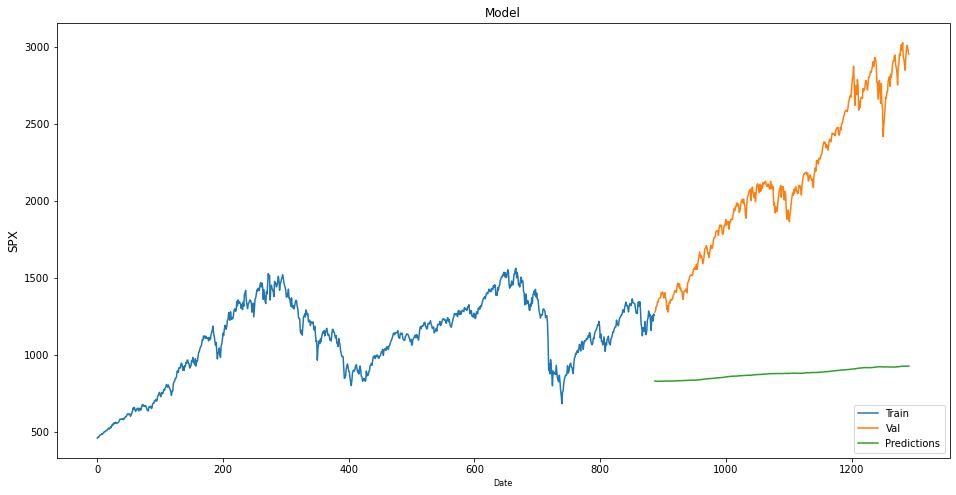

In [123]:
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=8)
plt.ylabel('SPX', fontsize=12)
plt.plot(train_['valeur'])
plt.plot(valid_[['valeur', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()


# Modèle GRU 

In [124]:
model_GRU = Sequential()

# Ajout d'une première couche LSTM et d'une régularisation Dropout
model_GRU.add(LSTM(units = 200, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model_GRU.add(Dropout(0.2))

# Ajout d'une deuxième couche LSTM et d'une régularisation Dropout
model_GRU.add(GRU(units = 50, return_sequences = True))
model_GRU.add(Dropout(0.2))

model_GRU.add(GRU(units = 50, return_sequences = True))
model_GRU.add(Dropout(0.2))

model_GRU.add(GRU(units = 50, return_sequences=True))
model_GRU.add(Dropout(0.2))

model_GRU.add(GRU(units = 50, return_sequences=True))
model_GRU.add(Dropout(0.2))

model_GRU.add(GRU(units = 50, return_sequences=True))
model_GRU.add(Dropout(0.2))

model_GRU.add(GRU(units = 50))
model_GRU.add(Dropout(0.2))

# Ajout de la couche de sortie
model_GRU.add(Dense(units = 1))

# Compilation du réseau
model_GRU.compile(
    optimizer = 'adam', 
    loss = 'mean_squared_error')

# Adapter le réseau à l'ensemble d'entraînement
model_GRU.fit(X_train, y_train, epochs = 100, batch_size = 32)


Epoch 1/100
23/23 [==============================] - 52s 1s/step - loss: 0.0132
Epoch 2/100
23/23 [==============================] - 25s 1s/step - loss: 0.0047
Epoch 3/100
23/23 [==============================] - 25s 1s/step - loss: 0.0029
Epoch 4/100
23/23 [==============================] - 25s 1s/step - loss: 0.0025
Epoch 5/100
23/23 [==============================] - 25s 1s/step - loss: 0.0021
Epoch 6/100
23/23 [==============================] - 25s 1s/step - loss: 0.0018
Epoch 7/100
23/23 [==============================] - 26s 1s/step - loss: 0.0015
Epoch 8/100
23/23 [==============================] - 25s 1s/step - loss: 0.0015
Epoch 9/100
23/23 [==============================] - 25s 1s/step - loss: 0.0017
Epoch 10/100
23/23 [==============================] - 25s 1s/step - loss: 0.0014
Epoch 11/100
23/23 [==============================] - 25s 1s/step - loss: 0.0015
Epoch 12/100
23/23 [==============================] - 26s 1s/step - loss: 0.0013
Epoch 13/100
23/23 [=================

In [133]:
predicted_stock_gru = model_GRU.predict(X_test)
predicted_stock_gru = scaler.inverse_transform(predicted_stock_gru)
train = données[:split_val]
valid = données[split_val:]
valid['Predictions'] = predicted_stock_gru
score = r2_score(y_test, predicted_stock_gru)
score

13/13 [==============================] - 4s 324ms/step


0.9859856703234279

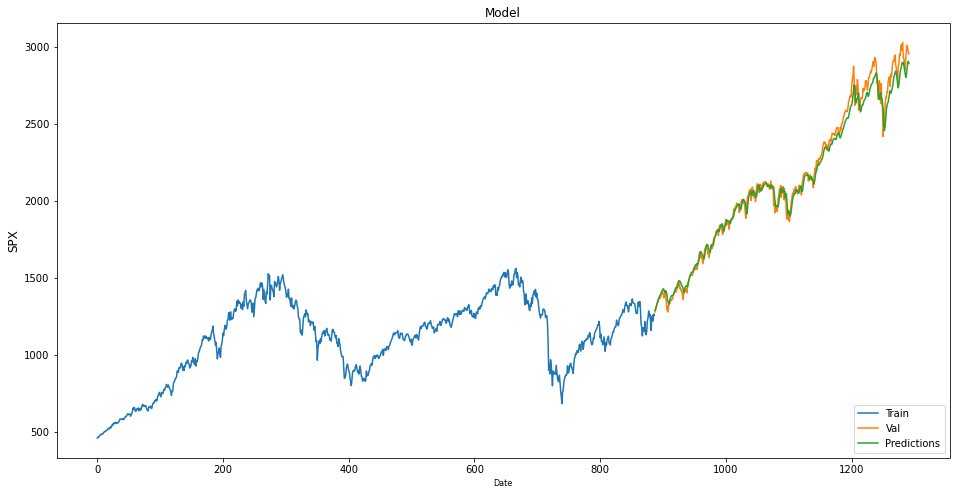

In [127]:
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=8)
plt.ylabel('SPX', fontsize=12)
plt.plot(train['valeur'])
plt.plot(valid[['valeur', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()


# Modèle CNN

In [129]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

# Paramétrage
input_shape = (X_train.shape[1], 1)
num_classes = 2

# mis en place du modèle
CNN = Sequential()
CNN.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape))
CNN.add(MaxPooling1D(pool_size=2))
CNN.add(LSTM(units=50, return_sequences=True))
CNN.add(Dropout(0.2))
CNN.add(Flatten())
CNN.add(Dense(1, activation='relu'))

#Compilation du modèle
CNN.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
CNN.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=32)

Epoch 1/100
23/23 [==============================] - 7s 128ms/step - loss: 0.0126 - accuracy: 0.0000e+00 - val_loss: 4742760.5000 - val_accuracy: 0.0000e+00
Epoch 2/100
23/23 [==============================] - 2s 81ms/step - loss: 0.0034 - accuracy: 0.0000e+00 - val_loss: 4742657.5000 - val_accuracy: 0.0000e+00
Epoch 3/100
23/23 [==============================] - 2s 82ms/step - loss: 0.0022 - accuracy: 0.0000e+00 - val_loss: 4742692.5000 - val_accuracy: 0.0000e+00
Epoch 4/100
23/23 [==============================] - 2s 81ms/step - loss: 0.0018 - accuracy: 0.0000e+00 - val_loss: 4743103.0000 - val_accuracy: 0.0000e+00
Epoch 5/100
23/23 [==============================] - 2s 73ms/step - loss: 0.0022 - accuracy: 0.0000e+00 - val_loss: 4742595.5000 - val_accuracy: 0.0000e+00
Epoch 6/100
23/23 [==============================] - 2s 80ms/step - loss: 0.0017 - accuracy: 0.0000e+00 - val_loss: 4742598.0000 - val_accuracy: 0.0000e+00
Epoch 7/100
23/23 [==============================] - 2s 79ms/st

In [130]:
predicted_stock_cnn = CNN.predict(X_test)
predicted_stock_cnn = scaler.inverse_transform(predicted_stock_cnn)
train = données[:split_val]
valid = données[split_val:]
valid['Predictions'] = predicted_stock_cnn
score = r2_score(y_test, predicted_stock_cnn)
score

13/13 [==============================] - 1s 24ms/step


0.792521547441496

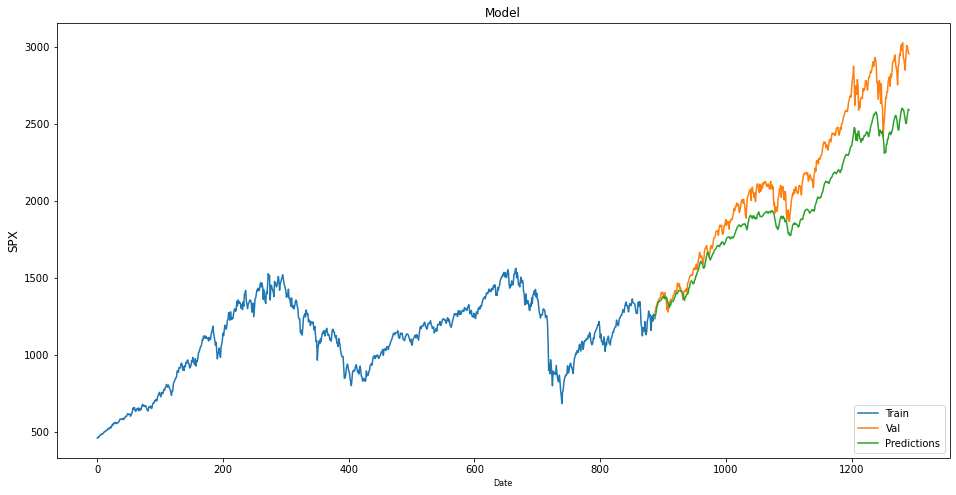

In [131]:
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=8)
plt.ylabel('SPX', fontsize=12)
plt.plot(train['valeur'])
plt.plot(valid[['valeur', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()


In [139]:
CNN.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_9 (Conv1D)           (None, 178, 64)           256       
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 89, 64)           0         
 1D)                                                             
                                                                 
 lstm_33 (LSTM)              (None, 89, 50)            23000     
                                                                 
 dropout_44 (Dropout)        (None, 89, 50)            0         
                                                                 
 flatten_2 (Flatten)         (None, 4450)              0         
                                                                 
 dense_10 (Dense)            (None, 1)                 4451      
                                                      

In [151]:
from prettytable  import PrettyTable

In [153]:
myTable = PrettyTable(["", "Accuracy", "MSE", "MAE"])

myTable.add_row(["LSTM", 
           str(round(r2_score(y_test, predicted_stock_lstm),2)), 
           str(round(mean_squared_error(y_test, predicted_stock_cnn),2)), 
           str(round(mean_absolute_error(y_test, predicted_stock_cnn),2)),
          ]
         )
myTable.add_row(["GRU", 
           str(round(r2_score(y_test, predicted_stock_gru),2)), 
           str(round(mean_squared_error(y_test, predicted_stock_gru),2)), 
           str(round(mean_absolute_error(y_test, predicted_stock_gru),2)),
          ]
         )
           
myTable.add_row(["CNN", 
           str(round(r2_score(y_test, predicted_stock_cnn),2)), 
           str(round(mean_squared_error(y_test, predicted_stock_cnn),2)), 
           str(round(mean_absolute_error(y_test, predicted_stock_cnn),2)),
          ]
         )
print(myTable)

+------+----------+----------+--------+
|      | Accuracy |   MSE    |  MAE   |
+------+----------+----------+--------+
| LSTM |   0.96   | 47909.06 | 184.94 |
| GRU  |   0.99   | 3236.06  | 42.55  |
| CNN  |   0.79   | 47909.06 | 184.94 |
+------+----------+----------+--------+
